
<div dir=ltr align=center>

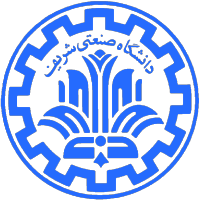

<font color=0F5298 size=7>
Machine Learning  <br>
<font color=2565AE size=5>
Computer Engineering Department <br>
Fall 2025 <br>
<font color=3C99D size=5>
    Project3 - FinFormer: Custom Transformer for Financial Sentiment <br>
<font color=696880 size=4>
    Mahdyar Mostashar - Sarina Farzadnasab - Sobhan Aghasi <br>

____

## Imports

In [1]:
!pip install nlpaug transformers torch datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 14.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import nlpaug.augmenter.word as naw
import numpy as np
import transformers
from tqdm import tqdm
import torch
import re
from datasets import load_dataset
from huggingface_hub import login
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import torch.nn as nn
import math
import io, requests


## Optional: Connect to drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

drive_path = '/content/drive/MyDrive/MLProject/data'

# Login to HF

In [ ]:
import os

hf_token = os.getenv('HF_TOKEN')
if hf_token:
    login(token=hf_token)

##  Data Preprocessing and Model Preparation

Creating data frame

In [ ]:
# Download the zip directly from the HuggingFace repo (no loading script needed)
import io, zipfile, requests

ZIP_URL = (
    "https://huggingface.co/datasets/takala/financial_phrasebank"
    "/resolve/main/data/FinancialPhraseBank-v1.0.zip"
 )

print("Downloading FinancialPhraseBank zip from HuggingFace...")
r = requests.get(ZIP_URL)
r.raise_for_status()
print(f"Downloaded {len(r.content) // 1024} KB")

file_configs = [
    ('Sentences_50Agree.txt', 'Sentences_50Agree'),
    ('Sentences_66Agree.txt', 'Sentences_66Agree'),
    ('Sentences_75Agree.txt', 'Sentences_75Agree'),
    ('Sentences_AllAgree.txt', 'Sentences_AllAgree'),
 ]

records = []

with zipfile.ZipFile(io.BytesIO(r.content)) as zf:
    all_names = zf.namelist()
    for filename, category_name in file_configs:
        matches = [n for n in all_names if n.endswith(filename)]
        if not matches:
            print(f"WARNING: {filename} not found in zip")
            continue
        print(f"Processing {matches[0]}...")
        with zf.open(matches[0]) as fh:
            for raw_line in fh:
                line = raw_line.decode('latin-1').strip()
                if not line:
                    continue
                parts = line.rsplit('@', 1)
                if len(parts) == 2:
                    records.append({
                        'category': category_name,
                        'sentence': parts[0].strip(),
                        'label': parts[1].strip(),
                    })

df = pd.DataFrame(records)

print("\nSuccess!")
print(f"Total rows: {len(df)}")
print("\nFirst 5 rows:")
print(df.head())
print("\nLast 5 rows:")
print(df.tail())

Downloaded 665 KB
Processing FinancialPhraseBank-v1.0/Sentences_50Agree.txt...
Processing FinancialPhraseBank-v1.0/Sentences_66Agree.txt...
Processing FinancialPhraseBank-v1.0/Sentences_75Agree.txt...
Processing FinancialPhraseBank-v1.0/Sentences_AllAgree.txt...

Success!
Total rows: 14780

First 5 rows:
            category                                           sentence  \
0  Sentences_50Agree  According to Gran , the company has no plans t...   
1  Sentences_50Agree  Technopolis plans to develop in stages an area...   
2  Sentences_50Agree  The international electronic industry company ...   
3  Sentences_50Agree  With the new production plant the company woul...   
4  Sentences_50Agree  According to the company 's updated strategy f...   

      label  
0   neutral  
1   neutral  
2  negative  
3  positive  
4  positive  

Last 5 rows:
                 category                                           sentence  \
14775  Sentences_AllAgree  Operating result for the 12-month peri

Plot distribution of each label

/tmp/ipython-input-2864877690.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=df, palette='viridis')


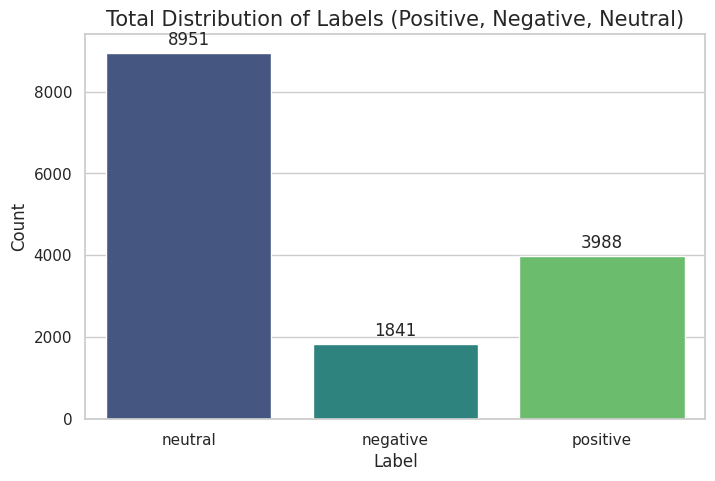

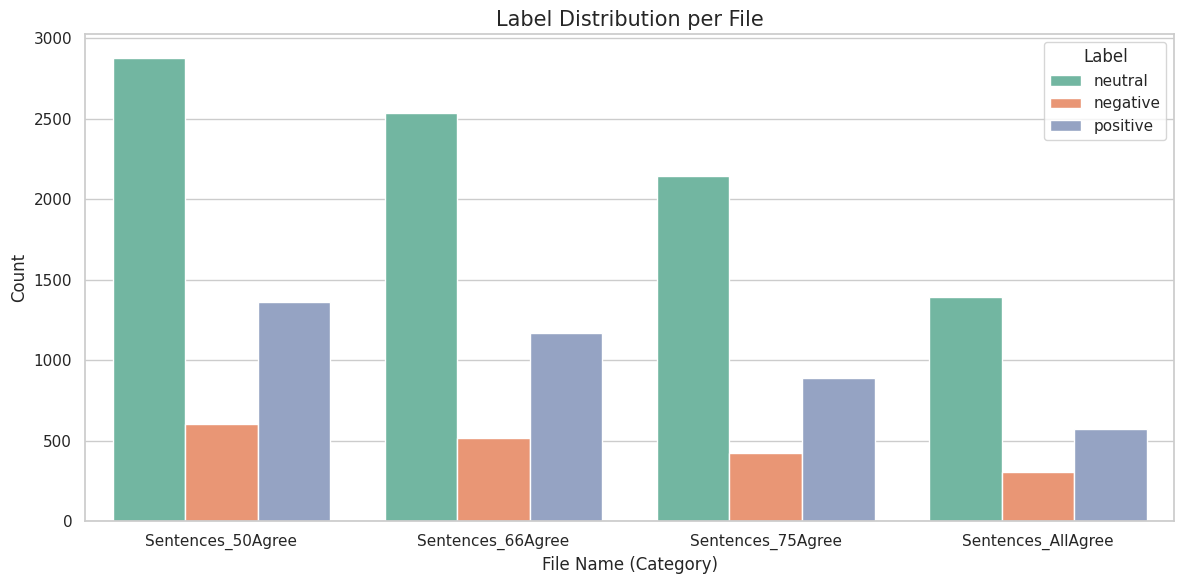

In [5]:
# 1. Set the visual style
sns.set_theme(style="whitegrid")

# --- PLOT 1: Total Distribution of Labels ---
plt.figure(figsize=(8, 5)) # Set the size of the graph

# Create the count plot
ax = sns.countplot(x='label', data=df, palette='viridis')

# Add title and labels
plt.title('Total Distribution of Labels (Positive, Negative, Neutral)', fontsize=15)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add the actual numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.show()


# --- PLOT 2: Distribution of Labels per File (Category) ---
plt.figure(figsize=(12, 6))

# We use 'hue' to split the bars by category
sns.countplot(x='category', hue='label', data=df, palette='Set2')

plt.title('Label Distribution per File', fontsize=15)
plt.xlabel('File Name (Category)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Label')

plt.tight_layout() # Adjust layout to prevent clipping
plt.show()


Contextual Word Embedding Augmentation

Loading BERT model (Contextual Augmentation)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

The following layers were not sharded: bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.self.query.weight, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.output.dense.bias, cls.predictions.transform.dense.weight, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.attention.self.value.bias, cls.predictions.decoder.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.self.key.weight, cls.predictions.transform.dense.bias, bert.embeddings.word_embeddings.weight, cls.predictions.transform.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.embeddings.token_type_embeddings.weight, cls.predictions.bias, bert.encoder.layer.*.intermediate.dense.weight, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, ber

Loading weights:   0%|          | 0/202 [00:00<?, ?it/s]


Target rows per class: 8951
------------------------------
Augmenting 'negative': Generating 7110 new sentences...


100%|██████████| 7110/7110 [09:22<00:00, 12.65it/s]


Augmenting 'positive': Generating 4963 new sentences...


100%|██████████| 4963/4963 [06:32<00:00, 12.65it/s]
/tmp/ipython-input-2423806125.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df_balanced, palette='viridis')




--- Balancing Complete ---
label
neutral     8951
negative    8951
positive    8951
Name: count, dtype: int64


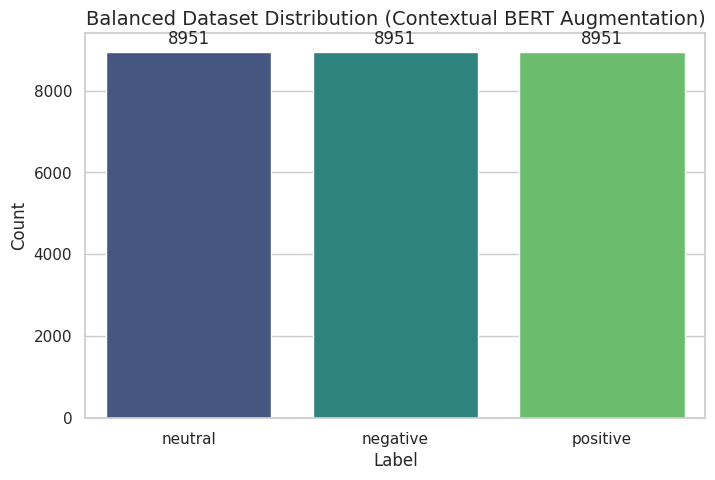


Examples of Generated Data:
          label                                           sentence
10792  negative  the international electronic industry reported...
10793  negative  a tinyurl challenge takes users to a new websi...
10794  negative  comparison with the ftse 100 index, rents rose...
10795  negative  consistent with its 2013 150 index, which is 9...
10796  negative  one of several challenges concerning the oil p...


In [6]:


# --- 1. THE FIX for "AttributeError: _convert_token_to_id" ---
# This line makes nlpaug compatible with the new transformers version
transformers.models.bert.tokenization_bert.BertTokenizer._convert_token_to_id = \
    lambda self, token: self.convert_tokens_to_ids(token)
# -------------------------------------------------------------

# 2. Initialize the BERT Augmenter
# We use 'bert-base-uncased' which understands English context very well.
print("Loading BERT model (Contextual Augmentation)...")
aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased',
    action="substitute",
    device='cuda' if torch.cuda.is_available() else 'cpu' # Use GPU if available
)

# 3. Analyze current data to find the target count
label_counts = df['label'].value_counts()
max_count = label_counts.max()

print(f"\nTarget rows per class: {max_count}")
print("-" * 30)

# 4. Create the Balanced Dataset
balanced_data = []

for label in df['label'].unique():
    # Get existing data for this label
    class_subset = df[df['label'] == label]
    existing_sentences = class_subset['sentence'].tolist()

    # Get the category reference (use the first one found)
    category_ref = class_subset['category'].iloc[0]

    # Add ALL existing original sentences first
    for sent in existing_sentences:
        balanced_data.append({
            'sentence': sent,
            'label': label,
            'category': category_ref
        })

    # Calculate how many artificial sentences we need
    needed = max_count - len(existing_sentences)

    if needed > 0:
        print(f"Augmenting '{label}': Generating {needed} new sentences...")

        # We use a progress bar to track generation
        with tqdm(total=needed) as pbar:
            generated = 0
            i = 0
            while generated < needed:
                # Cycle through existing sentences to create variations
                original_sent = existing_sentences[i % len(existing_sentences)]

                try:
                    # Generate Augmented Sentence
                    augmented_text = aug.augment(original_sent)

                    # Convert list to string if necessary
                    if isinstance(augmented_text, list):
                        augmented_text = augmented_text[0]

                    # Store the new data
                    balanced_data.append({
                        'sentence': augmented_text,
                        'label': label,
                        'category': 'Augmented_Data' # Mark as synthetic
                    })

                    generated += 1
                    pbar.update(1)

                except Exception as e:
                    # Sometimes very short sentences fail, just skip to next
                    pass

                i += 1

# 5. Convert list back to DataFrame
df_balanced = pd.DataFrame(balanced_data)

print("\n\n--- Balancing Complete ---")
print(df_balanced['label'].value_counts())

# --- 6. PLOT THE RESULTS ---
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df_balanced, palette='viridis')
plt.title('Balanced Dataset Distribution (Contextual BERT Augmentation)', fontsize=14)
plt.ylabel('Count')
plt.xlabel('Label')

# Add count labels on top of bars
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.show()

# Show a few examples of the new synthetic data
print("\nExamples of Generated Data:")
print(df_balanced[df_balanced['category'] == 'Augmented_Data'][['label', 'sentence']].head(5))


In [7]:
# Save to CSV
df_balanced.to_csv('balanced_dataset.csv', index=False, encoding='utf-8')

print("Dataset saved successfully as 'balanced_dataset.csv'")

Dataset saved successfully as 'balanced_dataset.csv'


Loading new dataset

In [4]:

def load_and_clean_data(file_path):
    """
    Loads a CSV file, prints class distribution and data preview,
    and removes missing values.

    Args:
        file_path (str): The location of the CSV file.

    Returns:
        pd.DataFrame: The loaded and cleaned DataFrame, or None if the file was not found.
    """
    df_loaded = None

    try:
        df_loaded = pd.read_csv(file_path)
        print(f"Successfully loaded {len(df_loaded)} rows from {file_path}")

        # --- Class Distribution Check ---
        print("\n--- Class Distribution Check ---")
        if 'label' in df_loaded.columns:
            print(df_loaded['label'].value_counts())
        else:
            print("Warning: 'label' column not found. Skipping class distribution check.")

        # --- Data Preview ---
        print("\n--- Data Preview (First 5 rows) ---")
        print(df_loaded.head())

        # --- Cleaning Missing Values ---
        if df_loaded.isnull().values.any():
            print("\nWarning: Found missing values. Cleaning now...")
            df_loaded = df_loaded.dropna()
            print(f"Data cleaned. New row count: {len(df_loaded)}")
        else:
            print("\nNo missing values found. Data is clean.")

        return df_loaded

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please check the filename.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

Pre process

In [ ]:
path = f'/content/balanced_dataset.csv'
df = load_and_clean_data(path)

Successfully loaded 26853 rows from /content/drive/MyDrive/MLProject/data/balanced_dataset.csv

--- Class Distribution Check ---
label
neutral     8951
negative    8951
positive    8951
Name: count, dtype: int64

--- Data Preview (First 5 rows) ---
                                            sentence    label  \
0  According to Gran , the company has no plans t...  neutral   
1  Technopolis plans to develop in stages an area...  neutral   
2  At the request of Finnish media company Alma M...  neutral   
3  In Sweden , Gallerix accumulated SEK denominat...  neutral   
4  The company supports its global customers in d...  neutral   

            category  
0  Sentences_50Agree  
1  Sentences_50Agree  
2  Sentences_50Agree  
3  Sentences_50Agree  
4  Sentences_50Agree  

No missing values found. Data is clean.


In [22]:


# Optional: Map common contractions (textspeak) to full words
# BERT understands "won't", but explicit text is often cleaner.
CONTRACTIONS = {
    "won't": "will not",
    "can't": "cannot",
    "n't": " not",
    "'re": " are",
    "'s": " is",
    "'d": " would",
    "'ll": " will",
    "'t": " not",
    "'ve": " have",
    "'m": " am"
}

def preprocess_text(text):
    text = str(text)

    # --- 1. NORMALIZATION START ---

    # A. Fix "Smart Quotes" and Windows encoding artifacts
    # Because you read files as 'latin-1', you might have curly quotes like ’ instead of '
    text = text.replace("’", "'").replace("‘", "'").replace("“", '"').replace("”", '"')

    # B. Lowercase (Essential for BERT uncased)
    text = text.lower()

    # C. Expand Contractions (Optional but recommended)
    for contraction, expansion in CONTRACTIONS.items():
        text = text.replace(contraction, expansion)

    # --- NORMALIZATION END ---

    # --- 2. CLEANING (From previous step) ---

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove User Mentions (@)
    text = re.sub(r'\@\w+', '', text)

    # Remove HTML
    text = re.sub(r'<.*?>', '', text)

    # Remove Numbers? -> NO.
    # In finance, "3.5%" vs "500" is a huge difference. Keep numbers.

    # Remove Non-ASCII characters (Optional)
    # This removes emojis or weird symbols, keeping only English letters/numbers/punctuation
    # If your data is strictly English, this is safe.
    text = re.sub(r'[^\x00-\x7f]', r'', text)

    # Clean whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# --- Apply ---
print("Applying Normalization and Cleaning...")
df['sentence'] = df['sentence'].apply(preprocess_text)
print("Done.")


Applying Normalization and Cleaning...
Done.


In [11]:
# Save to CSV
df.to_csv('balanced_normalized_dataset.csv', index=False, encoding='utf-8')

print("Dataset saved successfully as 'balanced_dataset.csv'")

Dataset saved successfully as 'balanced_dataset.csv'


Split dataset into train and validation

In [7]:
path = '/content/balanced_normalized_dataset.csv'
df = load_and_clean_data(path)

Successfully loaded 26853 rows from /content/drive/MyDrive/MLProject/data/balanced_normalized_dataset.csv

--- Class Distribution Check ---
label
neutral     8951
negative    8951
positive    8951
Name: count, dtype: int64

--- Data Preview (First 5 rows) ---
                                            sentence    label  \
0  according to gran , the company has no plans t...  neutral   
1  technopolis plans to develop in stages an area...  neutral   
2  at the request of finnish media company alma m...  neutral   
3  in sweden , gallerix accumulated sek denominat...  neutral   
4  the company supports its global customers in d...  neutral   

            category  
0  Sentences_50Agree  
1  Sentences_50Agree  
2  Sentences_50Agree  
3  Sentences_50Agree  
4  Sentences_50Agree  

No missing values found. Data is clean.


In [8]:

# 1. Split the data
# test_size=0.20  ->  20% for validation
# random_state=42 ->  Ensures the "random" shuffle is reproducible (same result every time you run it)
# shuffle=True    ->  Mixes the data thoroughly before splitting
# stratify=...    ->  Ensures both Train and Val have the exact same proportion of labels
train_df, val_df = train_test_split(
    df,
    test_size=0.20,
    random_state=42,
    shuffle=True,
    stratify=df['label']
)

# 2. Print the results to verify
print(f"Total Rows: {len(df)}")
print(f"Training Rows (80%): {len(train_df)}")
print(f"Validation Rows (20%): {len(val_df)}")

print("\n--- Training Set Distribution ---")
print(train_df['label'].value_counts())

print("\n--- Validation Set Distribution ---")
print(val_df['label'].value_counts())

train_df.to_csv('train_dataset.csv', index=False)
val_df.to_csv('val_dataset.csv', index=False)
print("\nFiles 'train_dataset.csv' and 'val_dataset.csv' have been saved.")


Total Rows: 26853
Training Rows (80%): 21482
Validation Rows (20%): 5371

--- Training Set Distribution ---
label
neutral     7161
negative    7161
positive    7160
Name: count, dtype: int64

--- Validation Set Distribution ---
label
positive    1791
neutral     1790
negative    1790
Name: count, dtype: int64

Files 'train_dataset.csv' and 'val_dataset.csv' have been saved.


Dataset class, Dataloader, Tokenizer

In [9]:

# 1. Load the Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 2. Measure the length of every sentence
token_lens = []

print("Calculating token lengths...")

# We iterate over every sentence in the dataframe
for txt in df['sentence']:
    # encode_plus handles the tokenization and adds special tokens [CLS], [SEP]
    tokens = tokenizer.encode(str(txt), max_length=512, truncation=True)
    token_lens.append(len(tokens))

# 3. Print Statistics
max_length = max(token_lens)

print(f"\n--- Results ---")
print(f"Maximum Token Length: {max_length}")



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Calculating token lengths...

--- Results ---
Maximum Token Length: 150


In [10]:
path = '/content/train_dataset.csv'
train_dataset = load_and_clean_data(path)

path = '/content/val_dataset.csv'
val_dataset = load_and_clean_data(path)

cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)

print(f"Current path: {cwd}")
print(f"Parent path:  {parent_dir}")

print("\n--- ls current path ---")
for name in sorted(os.listdir(cwd)):
    print(name)

print("\n--- ls parent path ---")
for name in sorted(os.listdir(parent_dir)):
    print(name)

Successfully loaded 21482 rows from /content/train_dataset.csv

--- Class Distribution Check ---
label
neutral     7161
negative    7161
positive    7160
Name: count, dtype: int64

--- Data Preview (First 5 rows) ---
                                            sentence     label  \
0  as earlier reported , nokian tyres is building...   neutral   
1  some individual jury members will now accompan...  negative   
2  agricultural for irrigation newspaper had 318,...  negative   
3  her concept enables a commercially available o...  positive   
4  global geosolutions technology will replace gl...  positive   

            category  
0  Sentences_50Agree  
1     Augmented_Data  
2     Augmented_Data  
3     Augmented_Data  
4     Augmented_Data  

No missing values found. Data is clean.
Successfully loaded 5371 rows from /content/val_dataset.csv

--- Class Distribution Check ---
label
positive    1791
neutral     1790
negative    1790
Name: count, dtype: int64

--- Data Preview (First 5 row

In [11]:

# Load Tokenizer (FinBERT)
MODEL_NAME = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class FinancialDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'sentence_text': text,
            # We still need .flatten() because it returns shape (1, max_len)
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long)
        }

# --- Re-setup DataLoaders with the fixed class ---

MAX_LEN = 155
BATCH_SIZE = 16
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}

def get_data_loaders(df, tokenizer, max_len, batch_size):
    df = df.copy()
    df['label_id'] = df['label'].map(label_map)

    ds = FinancialDataset(
        texts=df.sentence.to_numpy(),
        labels=df.label_id.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2,
        shuffle=True
    )

# Re-create loaders
train_data_loader = get_data_loaders(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = get_data_loaders(val_df, tokenizer, MAX_LEN, BATCH_SIZE)

# --- Verify ---
print("Checking batch again...")
data = next(iter(train_data_loader))
print(f"Batch loaded! Input IDs shape: {data['input_ids'].shape}")


Checking batch again...
Batch loaded! Input IDs shape: torch.Size([16, 155])


##  Model Architecture

### Self-Attention Class

In [12]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        self.head_dim = embed_dim // num_heads

        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)

        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, mask=None):
        batch_size, seq_length, _ = x.shape

        Q = self.q_proj(x)
        K = self.k_proj(x)
        V = self.v_proj(x)

        Q = Q.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-1e9'))

        attention_weights = torch.softmax(scores, dim=-1)
        attention_output = torch.matmul(attention_weights, V)

        attention_output = attention_output.transpose(1, 2).contiguous()
        attention_output = attention_output.view(batch_size, seq_length, self.embed_dim)

        return self.out_proj(attention_output)

### Transformer Block Implementation

In [13]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout_rate=0.1):
        super().__init__()

        self.attention = SelfAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        ffn_hidden_dim = 4 * embed_dim

        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ffn_hidden_dim),
            nn.ReLU(),
            nn.Linear(ffn_hidden_dim, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x, mask=None):
        norm_x = self.norm1(x)
        attention_out = self.attention(norm_x, mask=mask)

        x = x + self.dropout1(attention_out)

        norm_x = self.norm2(x)
        ffn_out = self.ffn(norm_x)
        x = x + self.dropout2(ffn_out)

        return x

### Building the FinancialTransformer Class

In [14]:
class FinancialTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, max_seq_length, dropout_rate=0.1):
        super().__init__()

        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.position_embedding = nn.Embedding(max_seq_length + 1, embed_dim)
        self.emb_dropout = nn.Dropout(dropout_rate)

        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, dropout_rate)
            for _ in range(4)
        ])

        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(embed_dim, 3)
        )

    def forward(self, input_ids, attention_mask=None):
        batch_size, seq_length = input_ids.shape

        if attention_mask is not None:
            cls_mask = torch.ones(batch_size, 1, dtype=attention_mask.dtype, device=attention_mask.device)
            extended_mask = torch.cat((cls_mask, attention_mask), dim=1)
            extended_mask = extended_mask.unsqueeze(1).unsqueeze(2)
        else:
            extended_mask = None

        tokens = self.token_embedding(input_ids)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)

        x = torch.cat((cls_tokens, tokens), dim=1)

        positions = torch.arange(0, seq_length + 1).unsqueeze(0).expand(batch_size, seq_length + 1).to(x.device)
        pos_emb = self.position_embedding(positions)

        x = self.emb_dropout(x + pos_emb)

        for block in self.blocks:
            x = block(x, mask=extended_mask)

        cls_output = x[:, 0, :]
        logits = self.classifier(cls_output)

        return logits

##  Training

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM = 256
NUM_HEADS = 8

print(f"Initializing model with Vocab Size: {VOCAB_SIZE} and Max Length: {MAX_LEN}")

model = FinancialTransformer(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    max_seq_length=MAX_LEN,
    dropout_rate=0.1
).to(device)

Initializing model with Vocab Size: 30522 and Max Length: 155


In [16]:
# Setup Optimizer and Loss Function
optimizer = torch.optim.AdamW(model.parameters(), lr=15e-5)
loss_fn = nn.CrossEntropyLoss()

EPOCHS = 10
LOG_STEPS = 400

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    progress_bar = tqdm(train_data_loader, desc=f'Epoch {epoch + 1}/{EPOCHS}')

    for step, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        optimizer.zero_grad()

        logits = model(input_ids=input_ids, attention_mask=attention_mask)

        loss = loss_fn(logits, targets)
        total_loss += loss.item()

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == targets).item()
        total_predictions += targets.size(0)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if (step + 1) % LOG_STEPS == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{step+1}/{len(train_data_loader)}], Loss: {loss.item():.4f}")

        progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

    avg_train_loss = total_loss / len(train_data_loader)
    train_accuracy = correct_predictions / total_predictions

    print(f"\n{'-'*30}")
    print(f"--- End of Epoch {epoch + 1} ---")
    print(f"Average Training Loss: {avg_train_loss:.4f}")
    print(f"Training Accuracy:     {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
    print(f"{'-'*30}\n")

Epoch 1/10:  30%|███       | 405/1343 [00:14<00:28, 32.70it/s, loss=0.7033]

Epoch [1/10], Step [400/1343], Loss: 1.0255


Epoch 1/10:  60%|█████▉    | 803/1343 [00:27<00:17, 31.72it/s, loss=0.9646]

Epoch [1/10], Step [800/1343], Loss: 0.7341


Epoch 1/10:  90%|████████▉ | 1206/1343 [00:40<00:04, 29.52it/s, loss=1.1658]

Epoch [1/10], Step [1200/1343], Loss: 0.5978


Epoch 1/10: 100%|██████████| 1343/1343 [00:44<00:00, 30.09it/s, loss=0.3914]



------------------------------
--- End of Epoch 1 ---
Average Training Loss: 0.8276
Training Accuracy:     0.6054 (60.54%)
------------------------------



Epoch 2/10:  30%|███       | 404/1343 [00:13<00:28, 32.41it/s, loss=0.4399]

Epoch [2/10], Step [400/1343], Loss: 0.3393


Epoch 2/10:  60%|█████▉    | 803/1343 [00:26<00:16, 31.83it/s, loss=0.5332]

Epoch [2/10], Step [800/1343], Loss: 0.5690


Epoch 2/10:  90%|████████▉ | 1205/1343 [00:39<00:04, 31.15it/s, loss=0.5127]

Epoch [2/10], Step [1200/1343], Loss: 0.7576


Epoch 2/10: 100%|██████████| 1343/1343 [00:43<00:00, 30.53it/s, loss=1.1677]



------------------------------
--- End of Epoch 2 ---
Average Training Loss: 0.5241
Training Accuracy:     0.7887 (78.87%)
------------------------------



Epoch 3/10:  30%|███       | 406/1343 [00:13<00:30, 30.80it/s, loss=0.1391]

Epoch [3/10], Step [400/1343], Loss: 0.3455


Epoch 3/10:  60%|█████▉    | 805/1343 [00:27<00:17, 30.10it/s, loss=0.3678]

Epoch [3/10], Step [800/1343], Loss: 0.1463


Epoch 3/10:  90%|████████▉ | 1205/1343 [00:40<00:04, 31.14it/s, loss=0.3901]

Epoch [3/10], Step [1200/1343], Loss: 0.2761


Epoch 3/10: 100%|██████████| 1343/1343 [00:45<00:00, 29.49it/s, loss=0.7423]



------------------------------
--- End of Epoch 3 ---
Average Training Loss: 0.3817
Training Accuracy:     0.8561 (85.61%)
------------------------------



Epoch 4/10:  30%|███       | 404/1343 [00:13<00:33, 28.16it/s, loss=0.7281]

Epoch [4/10], Step [400/1343], Loss: 0.2145


Epoch 4/10:  60%|█████▉    | 805/1343 [00:27<00:20, 26.17it/s, loss=0.1797]

Epoch [4/10], Step [800/1343], Loss: 0.5410


Epoch 4/10:  90%|████████▉ | 1205/1343 [00:40<00:05, 27.24it/s, loss=0.2074]

Epoch [4/10], Step [1200/1343], Loss: 0.4392


Epoch 4/10: 100%|██████████| 1343/1343 [00:45<00:00, 29.83it/s, loss=0.2534]



------------------------------
--- End of Epoch 4 ---
Average Training Loss: 0.2928
Training Accuracy:     0.8917 (89.17%)
------------------------------



Epoch 5/10:  30%|███       | 404/1343 [00:13<00:29, 31.42it/s, loss=0.2395]

Epoch [5/10], Step [400/1343], Loss: 0.0802


Epoch 5/10:  60%|██████    | 806/1343 [00:27<00:17, 30.98it/s, loss=0.5665]

Epoch [5/10], Step [800/1343], Loss: 0.3387


Epoch 5/10:  90%|████████▉ | 1206/1343 [00:40<00:04, 30.22it/s, loss=0.2504]

Epoch [5/10], Step [1200/1343], Loss: 0.0542


Epoch 5/10: 100%|██████████| 1343/1343 [00:45<00:00, 29.82it/s, loss=0.3706]



------------------------------
--- End of Epoch 5 ---
Average Training Loss: 0.2309
Training Accuracy:     0.9199 (91.99%)
------------------------------



Epoch 6/10:  30%|███       | 406/1343 [00:13<00:30, 31.10it/s, loss=0.3460]

Epoch [6/10], Step [400/1343], Loss: 0.2567


Epoch 6/10:  60%|█████▉    | 803/1343 [00:27<00:17, 30.99it/s, loss=0.5208]

Epoch [6/10], Step [800/1343], Loss: 0.1974


Epoch 6/10:  90%|████████▉ | 1204/1343 [00:40<00:04, 30.86it/s, loss=0.3846]

Epoch [6/10], Step [1200/1343], Loss: 0.1251


Epoch 6/10: 100%|██████████| 1343/1343 [00:45<00:00, 29.58it/s, loss=0.2145]



------------------------------
--- End of Epoch 6 ---
Average Training Loss: 0.1896
Training Accuracy:     0.9365 (93.65%)
------------------------------



Epoch 7/10:  30%|███       | 403/1343 [00:13<00:33, 27.85it/s, loss=0.3964]

Epoch [7/10], Step [400/1343], Loss: 0.5234


Epoch 7/10:  60%|█████▉    | 803/1343 [00:26<00:18, 28.91it/s, loss=0.1170]

Epoch [7/10], Step [800/1343], Loss: 0.1271


Epoch 7/10:  90%|████████▉ | 1203/1343 [00:40<00:04, 28.09it/s, loss=0.0335]

Epoch [7/10], Step [1200/1343], Loss: 0.0672


Epoch 7/10: 100%|██████████| 1343/1343 [00:45<00:00, 29.78it/s, loss=0.1653]



------------------------------
--- End of Epoch 7 ---
Average Training Loss: 0.1578
Training Accuracy:     0.9476 (94.76%)
------------------------------



Epoch 8/10:  30%|███       | 404/1343 [00:13<00:30, 30.64it/s, loss=0.0578]

Epoch [8/10], Step [400/1343], Loss: 0.2329


Epoch 8/10:  60%|█████▉    | 804/1343 [00:27<00:17, 30.41it/s, loss=0.3786]

Epoch [8/10], Step [800/1343], Loss: 0.0405


Epoch 8/10:  90%|████████▉ | 1204/1343 [00:40<00:04, 29.96it/s, loss=0.0622]

Epoch [8/10], Step [1200/1343], Loss: 0.0071


Epoch 8/10: 100%|██████████| 1343/1343 [00:45<00:00, 29.67it/s, loss=0.2906]



------------------------------
--- End of Epoch 8 ---
Average Training Loss: 0.1396
Training Accuracy:     0.9559 (95.59%)
------------------------------



Epoch 9/10:  30%|███       | 403/1343 [00:13<00:31, 29.85it/s, loss=0.0075]

Epoch [9/10], Step [400/1343], Loss: 0.2049


Epoch 9/10:  60%|█████▉    | 804/1343 [00:27<00:17, 31.20it/s, loss=0.0040]

Epoch [9/10], Step [800/1343], Loss: 0.0489


Epoch 9/10:  90%|████████▉ | 1203/1343 [00:41<00:04, 31.16it/s, loss=0.0059]

Epoch [9/10], Step [1200/1343], Loss: 0.2626


Epoch 9/10: 100%|██████████| 1343/1343 [00:45<00:00, 29.28it/s, loss=0.0165]



------------------------------
--- End of Epoch 9 ---
Average Training Loss: 0.1159
Training Accuracy:     0.9641 (96.41%)
------------------------------



Epoch 10/10:  30%|███       | 403/1343 [00:13<00:35, 26.35it/s, loss=0.3711]

Epoch [10/10], Step [400/1343], Loss: 0.0266


Epoch 10/10:  60%|█████▉    | 804/1343 [00:27<00:19, 27.25it/s, loss=0.2396]

Epoch [10/10], Step [800/1343], Loss: 0.0118


Epoch 10/10:  90%|████████▉ | 1204/1343 [00:40<00:05, 25.64it/s, loss=0.5254]

Epoch [10/10], Step [1200/1343], Loss: 0.0013


Epoch 10/10: 100%|██████████| 1343/1343 [00:45<00:00, 29.69it/s, loss=0.0082]


------------------------------
--- End of Epoch 10 ---
Average Training Loss: 0.1025
Training Accuracy:     0.9704 (97.04%)
------------------------------



In [17]:
# Save trained model/checkpoint to Google Drive
checkpoint_dir = os.path.join(drive_path, "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, "finformer_checkpoint.pt")

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "epoch": epoch,
    "avg_train_loss": avg_train_loss,
    "train_accuracy": train_accuracy,
    "max_len": MAX_LEN,
    "embed_dim": EMBED_DIM,
    "num_heads": NUM_HEADS,
    "vocab_size": VOCAB_SIZE,
    "label_map": label_map,
    "model_name": MODEL_NAME
}, checkpoint_path)

print(f"✅ Checkpoint saved to: {checkpoint_path}")

✅ Checkpoint saved to: /content/drive/MyDrive/MLProject/data/checkpoints/finformer_checkpoint.pt


In [ ]:
# Load a trained FinFormer checkpoint from a specific Google Drive path

def load_model_from_drive(checkpoint_path, load_optimizer_state=True):
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")

    checkpoint = torch.load(checkpoint_path, map_location=device)

    loaded_model = FinancialTransformer(
        vocab_size=checkpoint.get("vocab_size", VOCAB_SIZE),
        embed_dim=checkpoint.get("embed_dim", EMBED_DIM),
        num_heads=checkpoint.get("num_heads", NUM_HEADS),
        max_seq_length=checkpoint.get("max_len", MAX_LEN),
        dropout_rate=0.1
    ).to(device)

    loaded_model.load_state_dict(checkpoint["model_state_dict"])
    loaded_model.eval()

    loaded_optimizer = torch.optim.AdamW(loaded_model.parameters(), lr=15e-5)
    if load_optimizer_state and "optimizer_state_dict" in checkpoint:
        loaded_optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        for state in loaded_optimizer.state.values():
            for k, v in state.items():
                if torch.is_tensor(v):
                    state[k] = v.to(device)

    print(f"✅ Loaded checkpoint: {checkpoint_path}")
    print(f"   Saved epoch: {checkpoint.get('epoch', 'N/A')}")
    print(f"   Saved train acc: {checkpoint.get('train_accuracy', 'N/A')}")
    print(f"   Saved train loss: {checkpoint.get('avg_train_loss', 'N/A')}")

    return loaded_model, loaded_optimizer, checkpoint


# --- Set your specific Drive checkpoint path here ---
checkpoint_path = "/content/drive/MyDrive/MLProject/data/checkpoints/finformer_checkpoint.pt"

# Overwrite current model/optimizer with loaded state
model, optimizer, checkpoint = load_model_from_drive(checkpoint_path)

## Validation Evaluation

Validation Evaluation: 100%|██████████| 336/336 [00:04<00:00, 80.88it/s]



VALIDATION METRICS

Quantitative Evaluation Metrics (Weighted Average):
   Accuracy:  0.9155 (91.55%)
   Precision: 0.9181
   Recall:    0.9155
   F1-Score:  0.9155

------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative     0.9513    0.8615    0.9041      1790
     Neutral     0.9441    0.9531    0.9486      1790
    Positive     0.8590    0.9319    0.8939      1791

    accuracy                         0.9155      5371
   macro avg     0.9181    0.9155    0.9155      5371
weighted avg     0.9181    0.9155    0.9155      5371


Confusion Matrix (Raw Counts):
[[1542   36  212]
 [  22 1706   62]
 [  57   65 1669]]



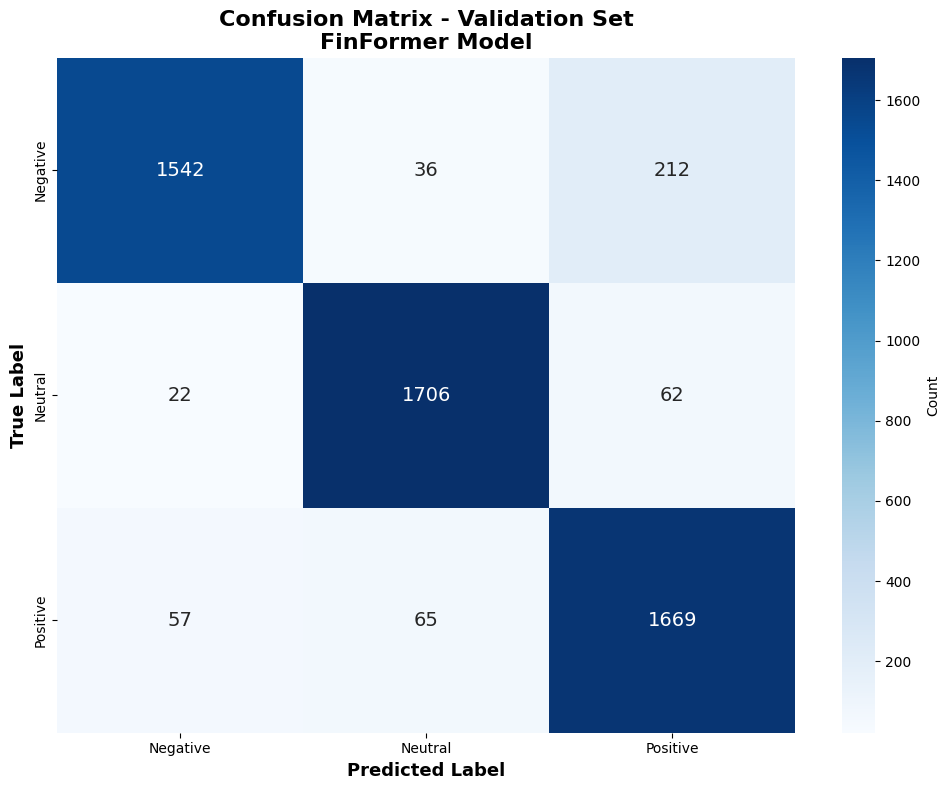

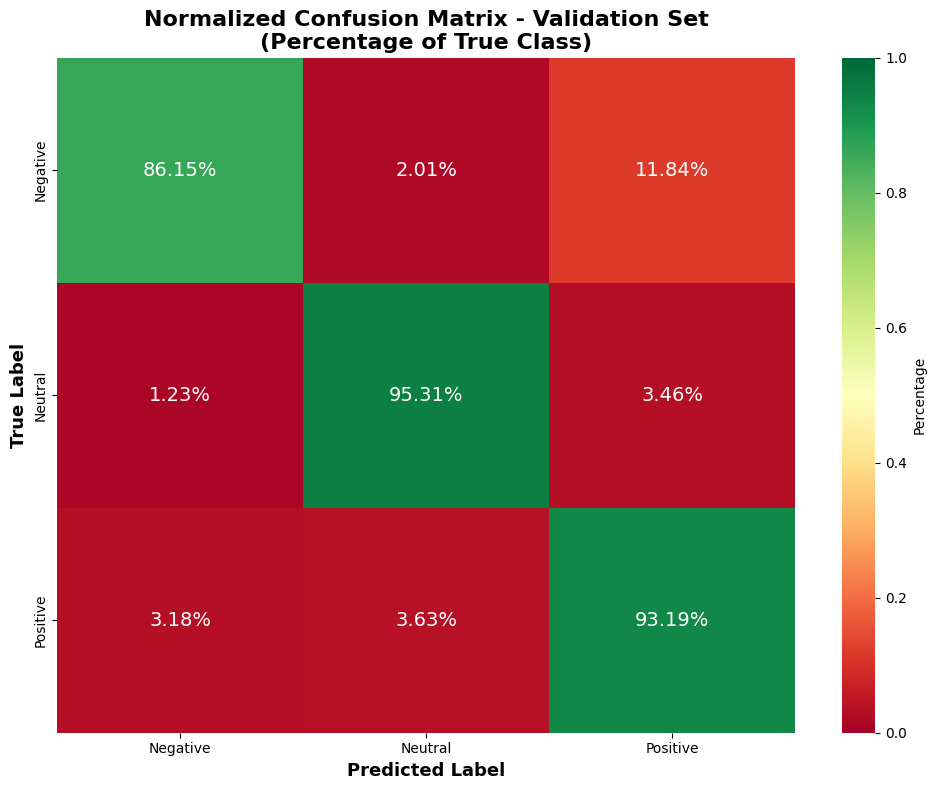

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model.eval()
all_predictions = []
all_targets = []

print("Collecting predictions from validation set...")
with torch.no_grad():
    for batch in tqdm(val_data_loader, desc='Validation Evaluation'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)
        
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(logits, dim=1)
        
        all_predictions.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

accuracy = accuracy_score(all_targets, all_predictions)
precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=0)
recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=0)
f1 = f1_score(all_targets, all_predictions, average='weighted', zero_division=0)

print("\n" + "="*60)
print("VALIDATION METRICS")
print("="*60)
print(f"\nQuantitative Evaluation Metrics (Weighted Average):")
print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print("\n" + "-"*60)

class_names = ['Negative', 'Neutral', 'Positive']
print("\nDetailed Classification Report:")
print(classification_report(all_targets, all_predictions, target_names=class_names, digits=4))

cm = confusion_matrix(all_targets, all_predictions)

print("\nConfusion Matrix (Raw Counts):")
print(cm)
print("\n" + "="*60)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 14})

plt.title('Confusion Matrix - Validation Set\nFinFormer Model', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Percentage'},
            annot_kws={'size': 14},
            vmin=0, vmax=1)

plt.title('Normalized Confusion Matrix - Validation Set\n(Percentage of True Class)', 
          fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## Test Evaluation

In [23]:
import os

test_csv_path = os.path.join(drive_path, 'test_sentences.csv')
if not os.path.exists(test_csv_path):
    raise FileNotFoundError(f"Test dataset not found at: {test_csv_path}")

test_df = pd.read_csv(test_csv_path)
if 'sentence' not in test_df.columns:
    raise ValueError("test_sentences.csv must contain a 'sentence' column")

print(f"Loaded {len(test_df)} test sentences from {test_csv_path}")

test_df['sentence'] = test_df['sentence'].astype(str).apply(preprocess_text)

class TestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'sentence_text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }

test_dataset = TestDataset(
    texts=test_df['sentence'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN,
 )

test_data_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=False,
 )

print(f"Test DataLoader created with {len(test_data_loader)} batches.")

Loaded 300 test sentences from /content/drive/MyDrive/MLProject/data/test_sentences.csv
Test DataLoader created with 19 batches.


In [24]:
print("\n" + "=" * 60)
print("GENERATING TEST PREDICTIONS")
print("=" * 60)

model.eval()
test_predictions = []

print("\nRunning model on test data...")
with torch.no_grad():
    for batch in tqdm(test_data_loader, desc='Test Prediction'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(logits, dim=1)

        test_predictions.extend(preds.cpu().numpy())

id_to_label = {0: 'negative', 1: 'neutral', 2: 'positive'}
test_predictions_labels = [id_to_label[pred] for pred in test_predictions]

output_df = pd.DataFrame({
    'sentence': test_df['sentence'],
    'predicted_sentiment': test_predictions_labels,
})

predictions_path = os.path.join(drive_path, 'test_predictions.csv')
output_df.to_csv(predictions_path, index=False, encoding='utf-8')

print(f"\nPredictions saved to {predictions_path}")
print("\nPrediction Distribution:")
print(output_df['predicted_sentiment'].value_counts())
print("\n" + "-" * 60)
print("\nSample Predictions (First 10):")
for idx, row in output_df.head(10).iterrows():
    sentiment = row['predicted_sentiment'].upper()
    sentence = row['sentence'][:80] + '...' if len(row['sentence']) > 80 else row['sentence']
    print(f"{idx + 1:2d}. [{sentiment:8s}] {sentence}")
print("=" * 60)


GENERATING TEST PREDICTIONS

Running model on test data...


Test Prediction: 100%|██████████| 19/19 [00:00<00:00, 50.54it/s]


Predictions saved to /content/drive/MyDrive/MLProject/data/test_predictions.csv

Prediction Distribution:
predicted_sentiment
positive    141
neutral      96
negative     63
Name: count, dtype: int64

------------------------------------------------------------

Sample Predictions (First 10):
 1. [POSITIVE] the helsinki-based industrial group reported a pre-tax profit of eur 45.2 mn for...
 2. [NEUTRAL ] net sales for the financial year are expected to remain at the same level as in ...
 3. [NEGATIVE] following the profit warning , the company is shares dropped by $12.5\%$ on the ...
 4. [NEUTRAL ] the contract , valued at approximately eur 15 mn , includes the delivery of adva...
 5. [NEGATIVE] operating loss widened to eur 4.2 mn in the third quarter from a loss of eur 1.1...
 6. [NEUTRAL ] the board of directors will propose a dividend of eur 1.15 per share for the fin...
 7. [POSITIVE] finnish it services provider tieto-x announced the acquisition of swedish softwa...
 8. [NEGATIV

## Attention Visualization


ATTENTION MECHANISM VISUALIZATION

Visualizing attention for first 5 test sentences...


Sentence 1/5: the helsinki-based industrial group reported a pre-tax profit of eur 45.2 mn for the first half of the year , up from eur 31.8 mn a year earlier .

Predicted Sentiment: POSITIVE
Confidence: Negative=4.75%, Neutral=0.01%, Positive=95.25%


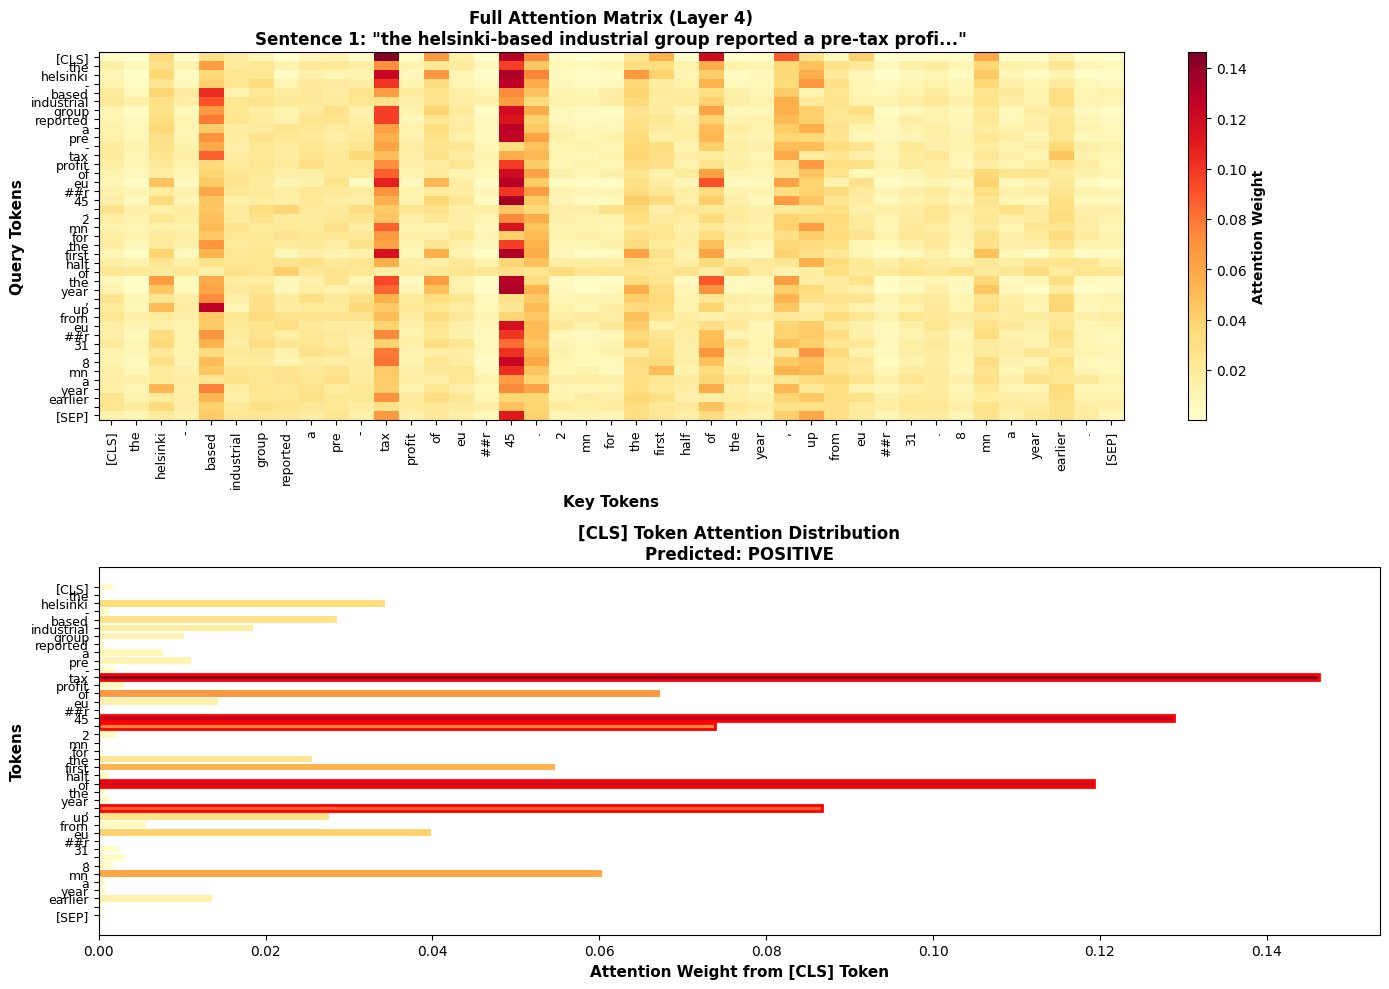


Top 5 Most Attended Tokens:
   1. 'tax' - Attention: 0.1463
   2. '45' - Attention: 0.1289
   3. 'of' - Attention: 0.1193
   4. ',' - Attention: 0.0867
   5. '.' - Attention: 0.0739



Sentence 2/5: net sales for the financial year are expected to remain at the same level as in 2011 .

Predicted Sentiment: NEUTRAL
Confidence: Negative=0.01%, Neutral=99.86%, Positive=0.13%


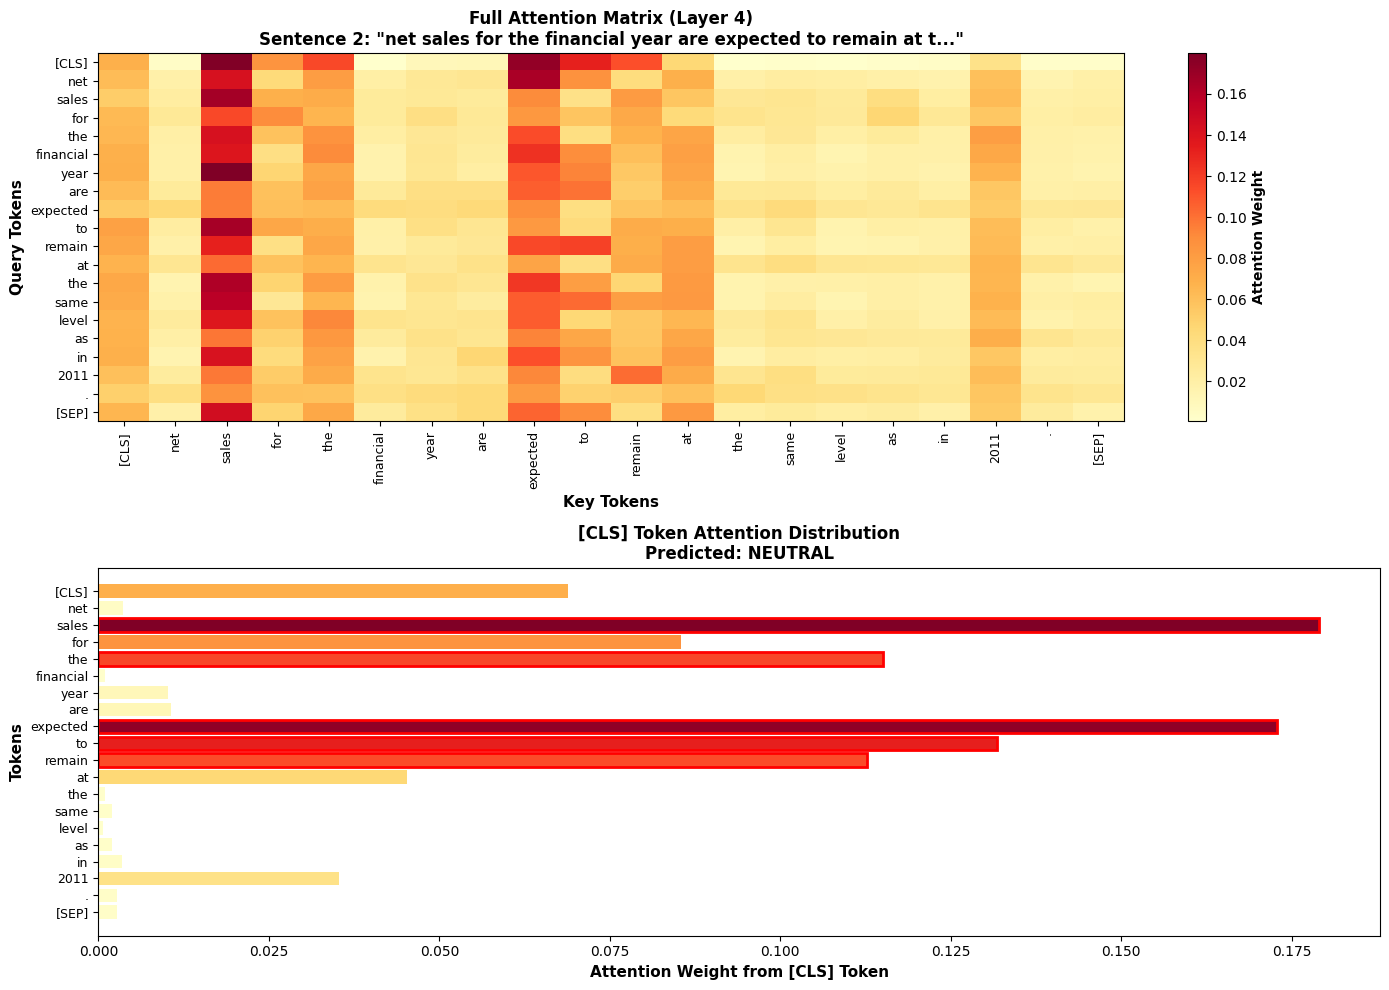


Top 5 Most Attended Tokens:
   1. 'sales' - Attention: 0.1790
   2. 'expected' - Attention: 0.1729
   3. 'to' - Attention: 0.1317
   4. 'the' - Attention: 0.1151
   5. 'remain' - Attention: 0.1126



Sentence 3/5: following the profit warning , the company is shares dropped by $12.5\%$ on the nordic exchange .

Predicted Sentiment: NEGATIVE
Confidence: Negative=99.03%, Neutral=0.61%, Positive=0.36%


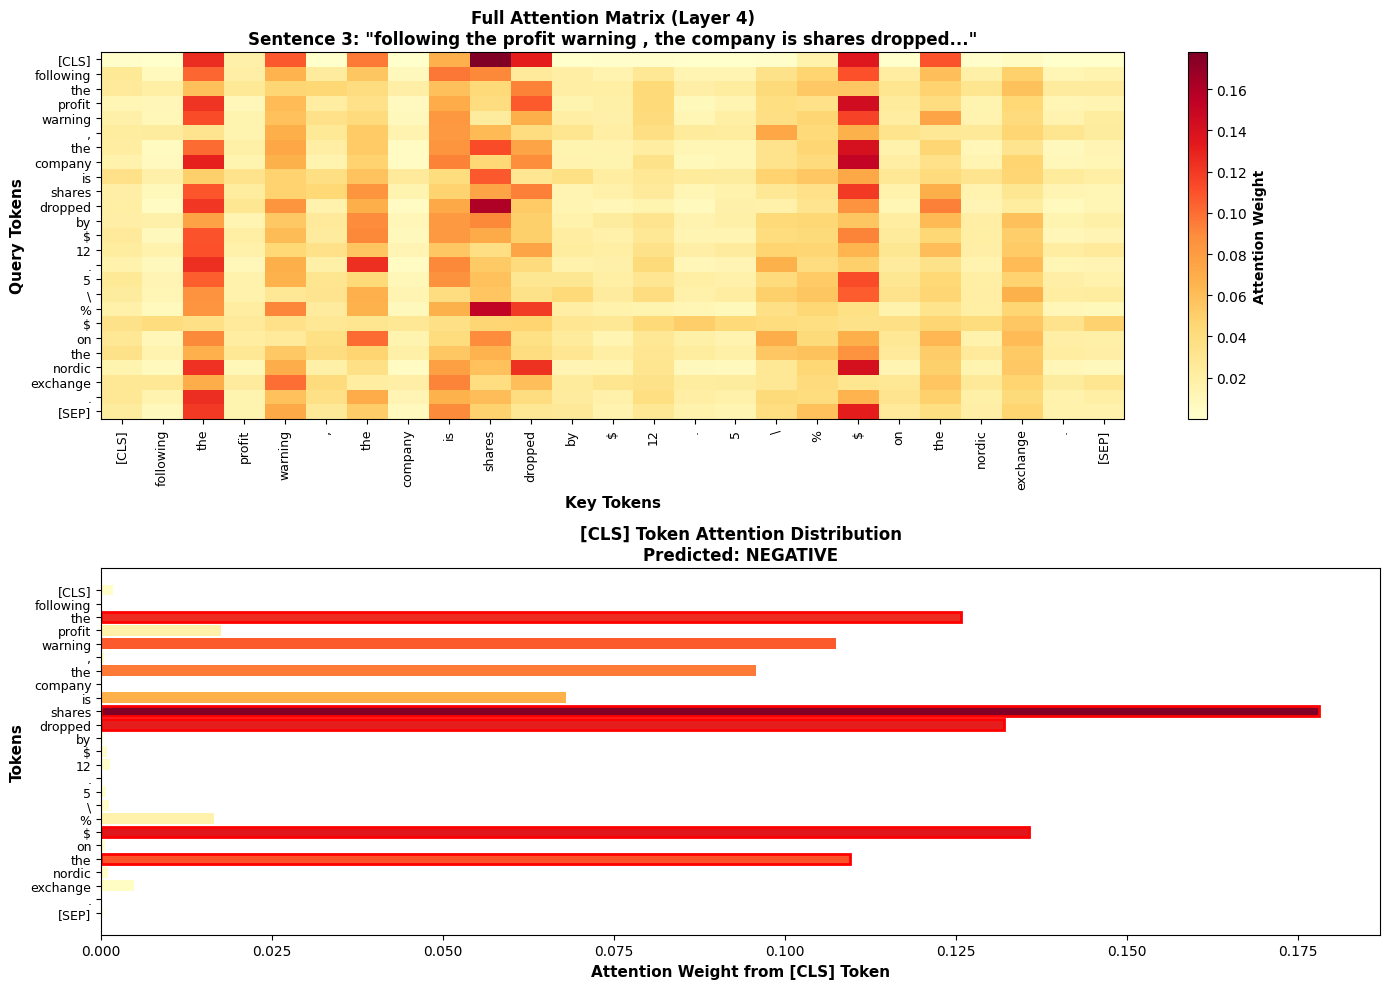


Top 5 Most Attended Tokens:
   1. 'shares' - Attention: 0.1780
   2. '$' - Attention: 0.1357
   3. 'dropped' - Attention: 0.1320
   4. 'the' - Attention: 0.1257
   5. 'the' - Attention: 0.1095



Sentence 4/5: the contract , valued at approximately eur 15 mn , includes the delivery of advanced automation systems for the new pulp mill .

Predicted Sentiment: NEUTRAL
Confidence: Negative=0.01%, Neutral=99.91%, Positive=0.08%


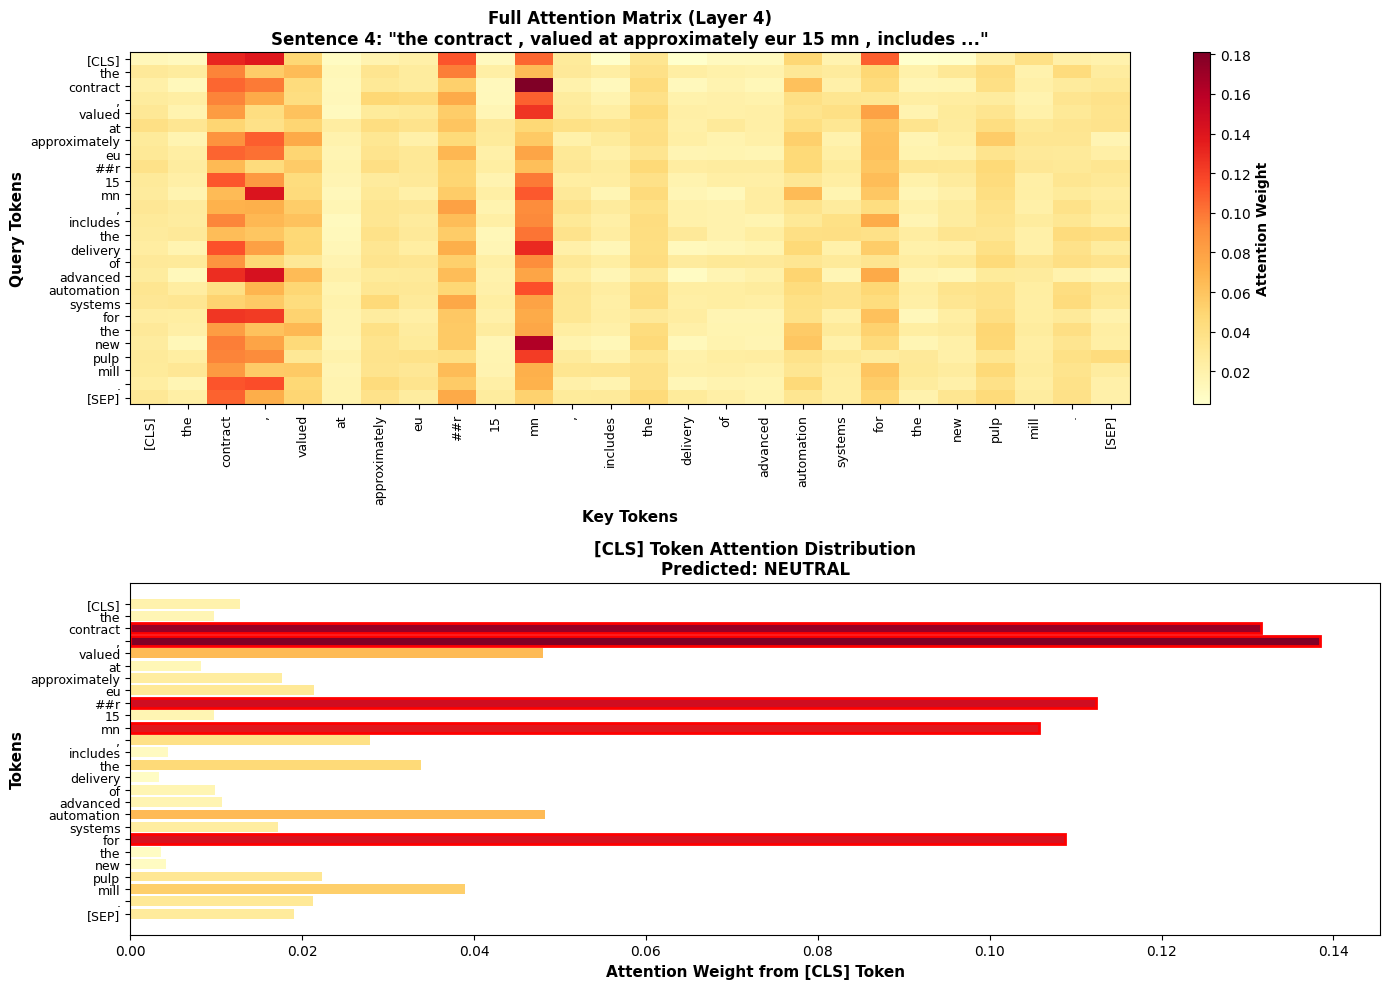


Top 5 Most Attended Tokens:
   1. ',' - Attention: 0.1385
   2. 'contract' - Attention: 0.1316
   3. '##r' - Attention: 0.1123
   4. 'for' - Attention: 0.1088
   5. 'mn' - Attention: 0.1057



Sentence 5/5: operating loss widened to eur 4.2 mn in the third quarter from a loss of eur 1.1 mn in the corresponding period last year .

Predicted Sentiment: NEGATIVE
Confidence: Negative=95.42%, Neutral=0.01%, Positive=4.58%


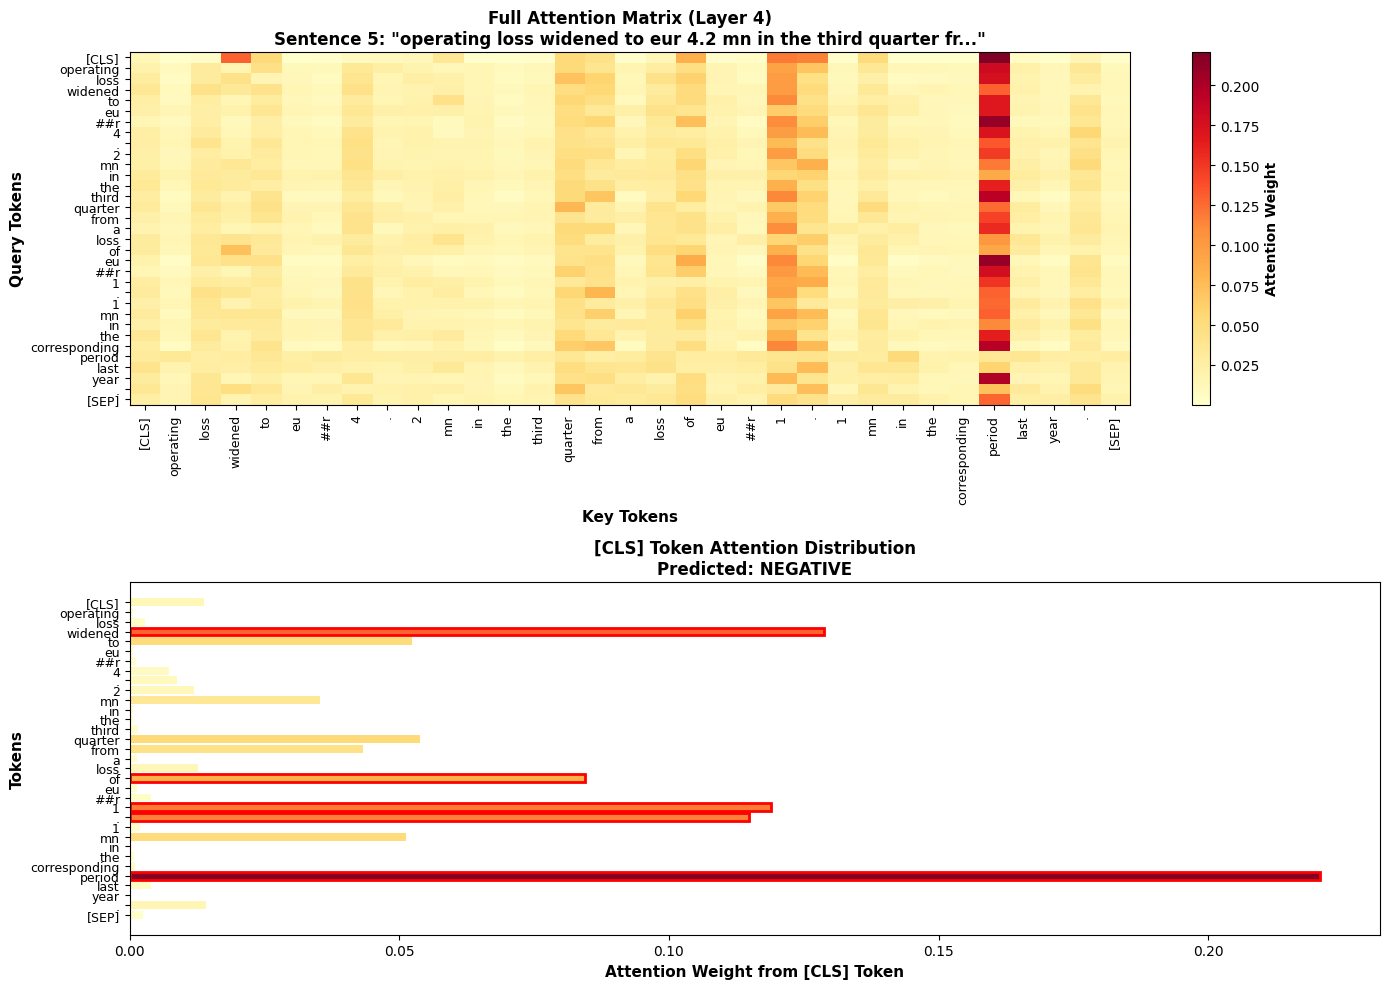


Top 5 Most Attended Tokens:
   1. 'period' - Attention: 0.2208
   2. 'widened' - Attention: 0.1288
   3. '1' - Attention: 0.1190
   4. '.' - Attention: 0.1149
   5. 'of' - Attention: 0.0843




In [27]:
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*60)
print("ATTENTION MECHANISM VISUALIZATION")
print("="*60)

num_visualize = 5
visualize_sentences = test_df['sentence'].head(num_visualize).tolist()

print(f"\nVisualizing attention for first {num_visualize} test sentences...\n")

for idx, sentence in enumerate(visualize_sentences, 1):
    print(f"\n{'='*70}")
    print(f"Sentence {idx}/{num_visualize}: {sentence}")
    print(f"{'='*70}")
    
    encoding = tokenizer(
        sentence,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        logits, attention_weights = model_with_attention(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_attention=True
        )
    
    pred_id = torch.argmax(logits, dim=1).item()
    predicted_label = id_to_label[pred_id]
    
    probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
    
    print(f"\nPredicted Sentiment: {predicted_label.upper()}")
    print(f"Confidence: Negative={probs[0]:.2%}, Neutral={probs[1]:.2%}, Positive={probs[2]:.2%}")
    
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())
    seq_len = attention_mask[0].sum().item()
    cls_attention = attention_weights[0, 0, :seq_len].cpu().numpy()
    actual_tokens = tokens[:seq_len]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    attention_matrix = attention_weights[0, :seq_len, :seq_len].cpu().numpy()
    
    im1 = ax1.imshow(attention_matrix, cmap='YlOrRd', aspect='auto')
    ax1.set_xticks(range(len(actual_tokens)))
    ax1.set_yticks(range(len(actual_tokens)))
    ax1.set_xticklabels(actual_tokens, rotation=90, fontsize=9)
    ax1.set_yticklabels(actual_tokens, fontsize=9)
    ax1.set_xlabel('Key Tokens', fontweight='bold', fontsize=11)
    ax1.set_ylabel('Query Tokens', fontweight='bold', fontsize=11)
    ax1.set_title(f'Full Attention Matrix (Layer 4)\nSentence {idx}: "{sentence[:60]}..."', 
                  fontweight='bold', fontsize=12)
    
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('Attention Weight', fontweight='bold')
    
    colors = plt.cm.YlOrRd(cls_attention / cls_attention.max())
    bars = ax2.barh(range(len(actual_tokens)), cls_attention, color=colors)
    
    ax2.set_yticks(range(len(actual_tokens)))
    ax2.set_yticklabels(actual_tokens, fontsize=9)
    ax2.set_xlabel('Attention Weight from [CLS] Token', fontweight='bold', fontsize=11)
    ax2.set_ylabel('Tokens', fontweight='bold', fontsize=11)
    ax2.set_title(f'[CLS] Token Attention Distribution\nPredicted: {predicted_label.upper()}', 
                  fontweight='bold', fontsize=12)
    ax2.invert_yaxis()
    
    top_indices = np.argsort(cls_attention)[-5:]
    for i in top_indices:
        bars[i].set_edgecolor('red')
        bars[i].set_linewidth(2)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTop 5 Most Attended Tokens:")
    sorted_indices = np.argsort(cls_attention)[::-1][:5]
    for rank, token_idx in enumerate(sorted_indices, 1):
        token = actual_tokens[token_idx]
        weight = cls_attention[token_idx]
        print(f"   {rank}. '{token}' - Attention: {weight:.4f}")
    
    print(f"\n{'='*70}\n")

In [28]:
# Modified model to extract attention weights
class FinancialTransformerWithAttention(nn.Module):
    """Modified version that returns attention weights from last layer"""
    def __init__(self, original_model):
        super().__init__()
        # Copy all attributes from original model
        self.token_embedding = original_model.token_embedding
        self.cls_token = original_model.cls_token
        self.position_embedding = original_model.position_embedding
        self.emb_dropout = original_model.emb_dropout
        self.blocks = original_model.blocks
        self.classifier = original_model.classifier
    
    def forward(self, input_ids, attention_mask=None, return_attention=False):
        batch_size, seq_length = input_ids.shape
        
        if attention_mask is not None:
            cls_mask = torch.ones(batch_size, 1, dtype=attention_mask.dtype, device=attention_mask.device)
            extended_mask = torch.cat((cls_mask, attention_mask), dim=1)
            extended_mask = extended_mask.unsqueeze(1).unsqueeze(2)
        else:
            extended_mask = None
        
        tokens = self.token_embedding(input_ids)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, tokens), dim=1)
        
        positions = torch.arange(0, seq_length + 1).unsqueeze(0).expand(batch_size, seq_length + 1).to(x.device)
        pos_emb = self.position_embedding(positions)
        x = self.emb_dropout(x + pos_emb)
        
        # Forward through blocks
        attention_weights = None
        for i, block in enumerate(self.blocks):
            # For last block, extract attention
            if return_attention and i == len(self.blocks) - 1:
                norm_x = block.norm1(x)
                
                # Extract attention computation from the last block
                Q = block.attention.q_proj(norm_x)
                K = block.attention.k_proj(norm_x)
                
                Q = Q.view(batch_size, seq_length + 1, block.attention.num_heads, block.attention.head_dim).transpose(1, 2)
                K = K.view(batch_size, seq_length + 1, block.attention.num_heads, block.attention.head_dim).transpose(1, 2)
                
                scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(block.attention.head_dim)
                
                if extended_mask is not None:
                    scores = scores.masked_fill(extended_mask == 0, float('-1e9'))
                
                attention_weights = torch.softmax(scores, dim=-1)
                # Average across heads
                attention_weights = attention_weights.mean(dim=1)  # [batch, seq_len+1, seq_len+1]
            
            x = block(x, mask=extended_mask)
        
        cls_output = x[:, 0, :]
        logits = self.classifier(cls_output)
        
        if return_attention:
            return logits, attention_weights
        return logits

# Wrap the trained model
model_with_attention = FinancialTransformerWithAttention(model)
model_with_attention.eval()

print("✅ Model wrapped for attention extraction")

✅ Model wrapped for attention extraction
